In [1]:
import numpy as np
import scipy as sp
from quaternion import from_rotation_matrix, quaternion

import sys
import os
#sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

from rlbench.environment import Environment
from rlbench.action_modes import ArmActionMode, ActionMode
from rlbench.observation_config import ObservationConfig
from rlbench.tasks import *

from perception import CameraIntrinsics, DepthImage
from scipy.spatial.transform import Rotation as R


from rrt import RRT
from franka_robot import FrankaRobot 

import stopit

def skew(x):
    return np.array([[0, -x[2], x[1]],
                    [x[2], 0, -x[0]],
                    [-x[1], x[0], 0]])


def sample_normal_pose(pos_scale, rot_scale):
    '''
    Samples a 6D pose from a zero-mean isotropic normal distribution
    '''
    pos = np.random.normal(scale=pos_scale)
        
    eps = skew(np.random.normal(scale=rot_scale))
    R = sp.linalg.expm(eps)
    quat_wxyz = from_rotation_matrix(R)

    return pos, quat_wxyz


class RandomAgent:

    def act(self, obs):
        delta_pos = [(np.random.rand() * 2 - 1) * 0.005, 0, 0]
        delta_quat = [0, 0, 0, 1] # xyzw
        gripper_pos = [np.random.rand() > 0.5]
        return delta_pos + delta_quat + gripper_pos


class NoisyObjectPoseSensor:

    def __init__(self, env):
        self._env = env

        self._pos_scale = [0.005] * 3
        self._rot_scale = [0.01] * 3

    def get_poses(self):
        objs = self._env._scene._active_task.get_base().get_objects_in_tree(exclude_base=True, first_generation_only=False)
        obj_poses = {}

        for obj in objs:
            name = obj.get_name()
            pose = obj.get_pose()

            pos, quat_wxyz = sample_normal_pose(self._pos_scale, self._rot_scale)
            gt_quat_wxyz = quaternion(pose[6], pose[3], pose[4], pose[5])
            perturbed_quat_wxyz = quat_wxyz * gt_quat_wxyz

            pose[:3] += pos
            pose[3:] = [perturbed_quat_wxyz.x, perturbed_quat_wxyz.y, perturbed_quat_wxyz.z, perturbed_quat_wxyz.w]

            obj_poses[name] = pose

        return obj_poses

class GraspableObjectPoseSensor:

    def __init__(self, env):
        self._env = env

        self._pos_scale = [0.005] * 3
        self._rot_scale = [0.01] * 3

    def get_poses(self):
        objs = self._env._scene._active_task.get_graspable_objects()
        obj_poses = {}

        for obj in objs:
            name = obj.get_name()
            pose = obj.get_pose()

            pos, quat_wxyz = sample_normal_pose(self._pos_scale, self._rot_scale)
            gt_quat_wxyz = quaternion(pose[6], pose[3], pose[4], pose[5])
            perturbed_quat_wxyz = quat_wxyz * gt_quat_wxyz

            pose[:3] += pos
            pose[3:] = [perturbed_quat_wxyz.x, perturbed_quat_wxyz.y, perturbed_quat_wxyz.z, perturbed_quat_wxyz.w]

            obj_poses[name] = pose

        return obj_poses

def move_to_location(task, obs, desired_pose, obj_pose_sensor, tolerance=0.5, isopen=1):
	while True:
		obj_poses = obj_pose_sensor.get_poses()
		current_gripper_pose = obs.gripper_pose
		delta = desired_pose - current_gripper_pose 	# this is the entire delta. First servo with XYZ.
		delta[3:] = np.zeros(4)		# don't change the quaternion 
		print(np.linalg.norm(delta))
		if(np.linalg.norm(delta)<tolerance):
			break
		obs, reward, terminate = task.step((current_gripper_pose+delta/20).tolist()+[isopen])
	return obs, reward, terminate


def move_rrt(task, source, dest, open=1):
	global rrt
	plan = rrt.plan(np.asarray(source), np.asarray(dest), None)

	#assert to_ctx_mgr == to_ctx_mgr.EXECUTING
	for p in plan:
		joints = p
		with stopit.ThreadingTimeout(0.5) as to_ctx_mgr:
			obs, reward, terminate = task.step(p.tolist()+[open])
		if to_ctx_mgr.state == to_ctx_mgr.EXECUTED:
			print("completed planning")
		elif to_ctx_mgr.state == to_ctx_mgr.TIMED_OUT:
			print("replan that path")
	return obs, reward, terminate

def check_shape_loc(graspable_pose_sensor, obs, shape_ind):
	objPoses = graspable_pose_sensor.get_poses()
	
	if shape_ind == 0:
		upright_s0 = objPoses["Shape"]
		upright_s0[3:] = obs.gripper_pose[3:]
		return upright_s0

	if shape_ind == 1:
		upright_s1 = objPoses["Shape1"]
		upright_s1[3:] = obs.gripper_pose[3:]
		return upright_s1
	
	if shape_ind == 3:
		upright_s3 = objPoses["Shape3"]
		upright_s3[3:] = obs.gripper_pose[3:]
		return upright_s3

def test_if_grasped(obs, objs, objname):
	for obj in objs:
		name = obj.get_name()

		pose = obj.get_pose()
		print("name and pose", name, pose)

		if(name==objname):
			err = np.linalg.norm(obs.gripper_pose[0:3]-pose[0:3])
			print('Err = ', err)
			if err > 0.1:
				print('Shape not picked up')
				return False
	return True

/home/rohan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rohan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rohan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rohan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: Futu

In [2]:
action_mode = ActionMode(ArmActionMode.ABS_EE_POSE) # See rlbench/action_modes.py for other action modes
env = Environment(action_mode, '', ObservationConfig(), False, static_positions=True)
task = env.get_task(EmptyContainer) # available tasks: EmptyContainer, PlayJenga, PutGroceriesInCupboard, SetTheTable
agent = RandomAgent()
obj_pose_sensor = NoisyObjectPoseSensor(env)
graspable_pose_sensor = GraspableObjectPoseSensor(env)

descriptions, obs = task.reset()
print(descriptions)

['empty the container in the to red container', 'clear all items from the large tray and put them in the red tray', 'move all objects from the large container and drop them into the smaller red one', 'remove whatever you find in the big box in the middle and leave them in the red one', 'grasp and move all objects into the red container']


In [3]:
fr = FrankaRobot()
rrt = RRT(fr, None)

arm = env._scene._active_task.robot.arm

objPoses = obj_pose_sensor.get_poses()

# First move the robot from initial pose to waypoint 2
curr_pos = obs.gripper_pose

waypoint2 = objPoses["waypoint2"]
upright_w2 = waypoint2
upright_w2[3:] = (0,1,0,0) #obs.gripper_pose[3:] upright constraint

waypoint3 = objPoses["waypoint3"]
upright_w3 = waypoint3
upright_w3[3:] = (0,1,0,0) #obs.gripper_pose[3:] upright constraint

obs, reward, terminate = move_rrt(task, curr_pos, waypoint2)

RRT: Sampled 52 nodes in 0.02s
RRT: Found a path! Path length is 55.
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning


In [ ]:
print(upright_w2)

In [4]:
def get_scanmap_location(xoffset, yoffset, lspx = np.linspace(-0.09, 0.15, 25), lspy = np.linspace(-0.12,0.12,25)):
    pose = [0.25753284, -0.00273565, 0.947497, 0, 1, 0, 0]  # pose of upright_w2
    pose[0] -= lspx[xoffset]
    pose[1] -= lspy[yoffset]
    return pose


def scan_container(obs):
    images=[]
    prev_wp = obs.gripper_pose
    ctr = 0
    for i in range(25):
        for j in range(25):
            ctr+=1
            print(ctr)
            waypoint3 = get_scanmap_location(i,j)
            obs, reward, terminate = move_rrt(task, prev_wp, waypoint3)
            prev_wp = waypoint3.copy()
            images.append(DepthImage(obs.wrist_depth, frame='world'))
    
    centres = [img[64,64] for img in images]
    centres = np.array(centres)
    centres = centres.reshape((25,25))
    thr = np.min(centres)+ (np.max(centres)-np.min(centres))/1.2
    c2 = centres.copy()
    c2[c2<thr]=0
    c2[c2>=thr]=1
    return obs, reward, terminate, images, c2

In [15]:
obs, reward, terminate, images, c2 = scan_container(obs)

1
RRT: Sampled 13 nodes in 0.01s
RRT: Found a path! Path length is 16.
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
2
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
3
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
4
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
5
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
6
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed plan

completed planning
completed planning
57
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
58
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
59
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
60
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
61
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
62
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
63
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
64
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
com

RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
115
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
116
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
117
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
118
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
119
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
120
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
121
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning

RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
172
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
173
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
174
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
175
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
176
RRT: Sampled 23 nodes in 0.00s
RRT: Found a path! Path length is 26.
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
comple

completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
227
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
228
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
229
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
230
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
231
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
232
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Pat

completed planning
completed planning
282
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
283
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
284
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
285
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
286
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
287
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
288
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
289
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length i

completed planning
339
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
340
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
341
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
342
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
343
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
344
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
345
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
346
RRT: Sampled 1 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed plan

396
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
397
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
398
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
399
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
400
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
401
RRT: Sampled 23 nodes in 0.00s
RRT: Found a path! Path length is 26.
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
co

completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
452
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
453
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
454
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
455
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
456
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
457
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Pat

completed planning
completed planning
507
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
508
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
509
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
510
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
511
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
512
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
513
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
514
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length i

completed planning
564
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
565
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
566
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
567
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
568
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
569
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
570
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
571
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed plan

621
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
622
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
623
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
624
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning
625
RRT: Sampled 0 nodes in 0.00s
RRT: Found a path! Path length is 3.
completed planning
completed planning
completed planning


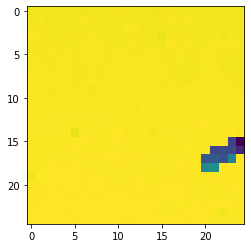

In [16]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
centres = [img[64,64] for img in images]
centres = np.array(centres)
centres = centres.reshape((25,25))
plt.imshow(centres)
plt.show()

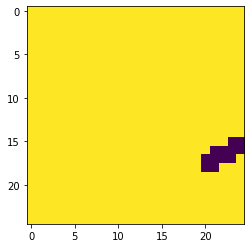

In [17]:
thr = np.min(centres)+ (np.max(centres)-np.min(centres))/1.2
c2 = centres.copy()
c2[c2<thr]=0
c2[c2>=thr]=1
plt.imshow(c2)
plt.show()

In [18]:
def pickup_random_shape(c2):
    xpos, ypos = np.where(c2==0)
    val = np.random.choice(len(xpos))
    pickuploc = xpos[val], ypos[val]
    print(pickuploc)
    shapepos = get_scanmap_location(*pickuploc)
    shapepos[0]+=0.01
    shapepos[1]+=0.01
    shapepos[2]-=0.2
    obs, reward, terminate = move_rrt(task, waypoint2, shapepos)
    obs, reward, terminate = task.step((obs.gripper_pose).tolist()+[0])
    obs, reward, terminate = move_rrt(task, shapepos, waypoint2, 0)
    obs, reward, terminate = move_rrt(task, waypoint2, waypoint3, 0)
    droploc = waypoint3.copy()
    droploc[2]-=0.1
    obs, reward, terminate = move_rrt(task, waypoint3, droploc, 0)
    obs, reward, terminate = task.step((obs.gripper_pose).tolist()+[1])
    obs, reward, terminate = move_rrt(task, droploc, waypoint3)
    obs, reward, terminate = move_rrt(task, waypoint3, waypoint2)
    
    return obs, reward, terminate

In [19]:
obs, reward, terminate = pickup_random_shape(c2)
#obs, reward, terminate, images, c2 = scan_container(obs)

(17, 20)
RRT: Sampled 21 nodes in 0.01s
RRT: Found a path! Path length is 24.
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning


Traceback (most recent call last):
  File "<ipython-input-1-50bf24dfd2f6>", line 126, in move_rrt
    obs, reward, terminate = task.step(p.tolist()+[open])
  File "/home/rohan/.local/lib/python3.6/site-packages/rlbench/task_environment.py", line 216, in step
    self._ee_action(list(arm_action))
  File "/home/rohan/.local/lib/python3.6/site-packages/rlbench/task_environment.py", line 131, in _ee_action
    self._pyrep.step()
  File "/home/rohan/.local/lib/python3.6/site-packages/pyrep/pyrep.py", line 190, in step
    sim.simExtStep()
  File "/home/rohan/.local/lib/python3.6/site-packages/pyrep/backend/sim.py", line 72, in simExtStep
    lib.simExtStep(stepIfRunning)
stopit.utils.TimeoutException


replan that path
RRT: Sampled 22 nodes in 0.00s
RRT: Found a path! Path length is 24.


Traceback (most recent call last):
  File "<ipython-input-1-50bf24dfd2f6>", line 126, in move_rrt
    obs, reward, terminate = task.step(p.tolist()+[open])
  File "/home/rohan/.local/lib/python3.6/site-packages/rlbench/task_environment.py", line 216, in step
    self._ee_action(list(arm_action))
  File "/home/rohan/.local/lib/python3.6/site-packages/rlbench/task_environment.py", line 131, in _ee_action
    self._pyrep.step()
  File "/home/rohan/.local/lib/python3.6/site-packages/pyrep/pyrep.py", line 190, in step
    sim.simExtStep()
  File "/home/rohan/.local/lib/python3.6/site-packages/pyrep/backend/sim.py", line 72, in simExtStep
    lib.simExtStep(stepIfRunning)
stopit.utils.TimeoutException


replan that path
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
RRT: Sampled 24 nodes in 0.00s
RRT: Found a path! Path length is 27.
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
completed planning
co

In [ ]:
depth = obs.wrist_depth
depth_image = DepthImage(depth, frame='world')
rgb = obs.wrist_rgb
plt.imshow(depth_image.data)#[64:, 64:])
plt.show()